In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col, split, floor
import matplotlib.pyplot as plt


In [ ]:
from pyspark.sql.functions import explode, split, col

# Create a Spark session with MongoDB support
spark = SparkSession.builder \
    .appName("BookGenomeProject") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/book_genome.books") \
    .getOrCreate()

# Read JSON files into a DataFrame
books_df = spark.read.json(r"C:\Users\aleks\Documents\Maths\Files\book-genome\book_dataset\raw\survey_answers.json")

# Show the first 5 rows of the dataset to get an overview
books_df.show(5)

# Print the schema to understand the structure
books_df.printSchema()

# Drop rows with missing 'item_id' or 'score' (since 'title', 'genres', 'tags' do not exist)
books_df = books_df.dropna(subset=["item_id", "score"])


In [ ]:
# Average rating for every book
average_scores_df = books_df.groupBy("item_id").agg({"score": "avg"})

# Filter out rows with average score less than 1
filtered_average_scores_df = average_scores_df.filter(col("avg(score)") >= 1)

# Show the filtered results
filtered_average_scores_df.show()

In [ ]:
# Amount of ratings for each tag
tag_counts_df = books_df.groupBy("tag_id").count()
tag_counts_df.show()

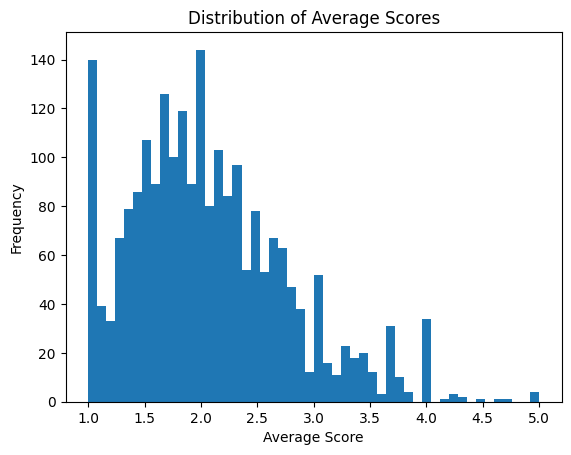

In [ ]:
# Plotting the average score distribution
average_scores = filtered_average_scores_df.toPandas()
plt.hist(average_scores['avg(score)'], bins=50)
plt.xlabel('Average Score')
plt.ylabel('Frequency')
plt.title('Distribution of Average Scores')
plt.show()

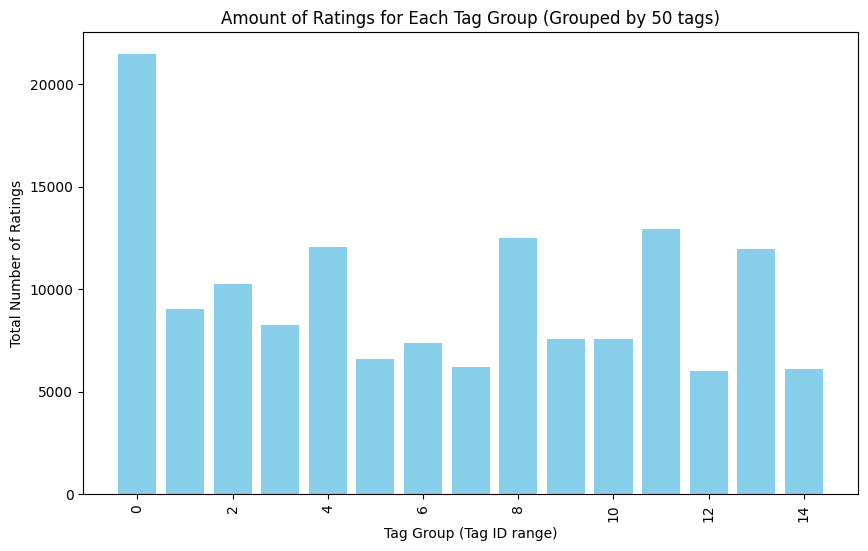

In [28]:
# Create a new column 'tag_group' which groups tag_ids into sets of 50
tag_counts_df = tag_counts_df.withColumn('tag_group', floor(col('tag_id') / 50))

# Group by the new 'tag_group' column and calculate the sum of counts for each group
tag_group_counts_df = tag_counts_df.groupBy('tag_group').agg({'count': 'sum'})

# Convert to Pandas DataFrame for visualization
tag_group_counts_pandas_df = tag_group_counts_df.toPandas()

# Plotting a bar chart for the grouped tag counts
plt.figure(figsize=(10, 6))
plt.bar(tag_group_counts_pandas_df['tag_group'], tag_group_counts_pandas_df['sum(count)'], color='skyblue')
plt.xlabel('Tag Group (Tag ID range)')
plt.ylabel('Total Number of Ratings')
plt.title('Amount of Ratings for Each Tag Group (Grouped by 50 tags)')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()